In [3]:
import sys, os
sys.path.append("C:/Users/pjsin/Documents/cantera/build/python")
import cantera as ct
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import scipy.optimize
from scipy.optimize import curve_fit
import numpy as np
from matplotlib import gridspec

hfont = {'fontname':'sans-serif','fontweight':550,'fontsize':10,'fontstretch':500}

### 1)      COMPILING TWO SUITABLE REACTION MECHANISMS (ONE WITH LMRR, ONE WITHOUT)
* Downloaded the ChemKin supplementary files created by Alzueta et al. in [“CO assisted NH3 oxidation”](https://www.sciencedirect.com/science/article/pii/S0010218022004552#bib0056)
* Used Cantera’s ck2yaml() function to convert the ChemKin files to yaml format (I had to do lots of minor modifications to the ChemKin files to make the conversion execute without errors)
* Saved the file as [alzuetamechanism.yaml](https://drive.google.com/file/d/1eXPhTu78T8qOhPhRbHjtv3HrkhsST9z0/view?usp=sharing)
* Created a second file, [alzuetamechanism_LMRR.yaml](https://drive.google.com/file/d/1ln--QaK9phmL9GVVyFz2-jMWSjjMKJ0b/view?usp=sharing) which replaces existing data with LMR data for Reactions 13, 69, and 164 (details discussed below)

#### 1.1) Reaction 10: O + O (+M) <=> O2 (+M)
* Changed the efficiency of ‘Ar’ to 1.0 in both [alzuetamechanism.yaml](https://drive.google.com/file/d/1eXPhTu78T8qOhPhRbHjtv3HrkhsST9z0/view?usp=sharing) and [alzuetamechanism_LMRR.yaml](https://drive.google.com/file/d/1ln--QaK9phmL9GVVyFz2-jMWSjjMKJ0b/view?usp=sharing)

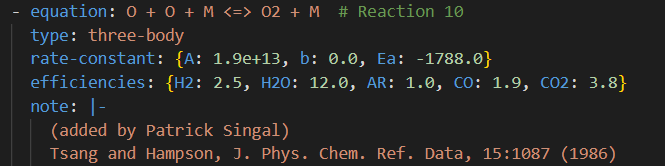

#### 1.2) Reaction 13: H + O2 (+M) <=> HO2 (+M)
* Colliders “M” and “H2O” lack data for b and Ea (without these parameters, the rate constant calculations become temperature-independent)
* Found a potential source for the eig0 given colliders ‘Ar’, ‘H2O’, ‘M’, and ‘O2’ from Table 1 of [“An improved H2/O2 mechanism based on recent shock tube/laser absorption measurements”](https://drive.google.com/file/d/1SMABjAvOYOV0Vwij6QQJBS7a77AZh4wc/view?usp=sharing) (see screenshot below)
* Calculated data for collider “Ar” by graph-reading Fig. 5 of [“From theoretical reaction dynamics to chemical modeling of combustion”](https://drive.google.com/file/d/1Ykp_j7kyUZgFh54MJ66w8aOkr74EILx4/view?usp=sharing) and then performing non-linear regression using the Python code below. The resulting best-fit parameters were then plotted as Arrhenius functions alongside the original graph-read data to verify their accuracy.


NOTES FROM DISCUSSION W/ PROF BURKE (Mon, November 27th):

From jasper paper, can do fits using 3 data points (one at each temp). But there is a risk of overfitting. Maybe drop to two parameters and fit A and n, or A and Ea (leaving the 3rd param as zero). These values correspond to eig0 in our case. Cant use p d

* get k0,Ar at 10 torr from Klippenstein fig5 (but dont we get the k0 values from the troe fit already? is the 10 torr value from plog table just a backup plan in case the troe fit didnt work?)
* set eff_Ar = 1
* look at eff of other species in Jasper paper table
* calculate k0 of other species by doing k0_i=eff_i*k0_Ar
* put these three values (at each different T) into a Troe fit. Assume that F_cent and k_inf the same as for argon (we already got these from Fig 5 of klipp plus the troe fit ) (in troe fit, Xvec is just, for example, [(300,10torr),(500,10torr),(1000,10torr)])

Eventually we will have troe fits for every collider. After Ive gone through all the params for water rxn, verify that they are right. If so, then try to make some interesting plot6s. start with flame burning rate from Burke,Song paper. Then we'll repeat the process for every other collider. However, for other rxns we don't have fig5 to work from (we'll have to use theory rate constants for Ar from Stagni). After that we can use jasper params in same manner as above. My LMRR code doesn't accept Troe fits, so once done we'll have to use troe fit to calculate the rate constant at different T and the same set of Pressures as graph-read from Klipp 

##### **Step 1: PLOG fitting for Ar in reaction H + O2 (+Ar) <-> HO2 (+Ar)**

- {P: 1.316e-02, A: 1.13662e+35, b: -4.96606e-01, Ea: 3.35590e+01}
- {P: 1.316e-01, A: 1.20365e+35, b: -5.03779e-01, Ea: 5.65622e+01}
- {P: 3.947e-01, A: 1.19725e+35, b: -5.02971e-01, Ea: 7.25245e+01}
- {P: 1.000e+00, A: 1.17596e+35, b: -5.00284e-01, Ea: 9.27103e+01}
- {P: 3.000e+00, A: 1.13056e+35, b: -4.95365e-01, Ea: 1.21181e+02}
- {P: 1.000e+01, A: 1.09320e+35, b: -4.91679e-01, Ea: 1.68286e+02}
- {P: 3.000e+01, A: 9.72855e+34, b: -4.77838e-01, Ea: 2.11753e+02}
- {P: 1.000e+02, A: 8.66276e+34, b: -4.64944e-01, Ea: 2.89233e+02}


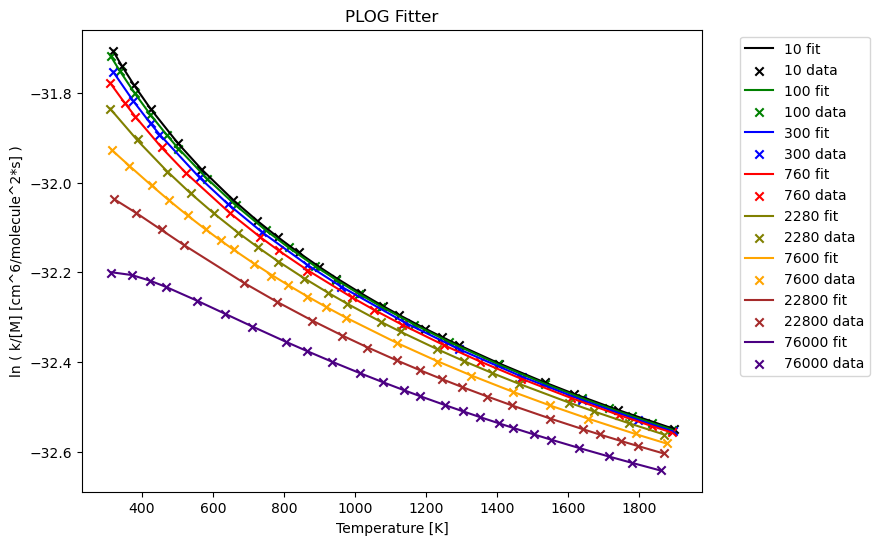

In [8]:
# def plog_fit():
#     path="G:\\Mon disque\\Columbia\\Burke Lab\\01 Mixture Rules Project\\"
#     fname="rateConstantCalculations_SKJFig5_truncated.csv"
#     p_list = [10,100,300,760,2280,7600,22800,76000]
#     for p in p_list:
#         def arrhenius_eq(T,A,n,Ea):
#             Rcal=1.987 #cal/molK
#             return np.log(A) + n*np.log(T)+ (-Ea/(Rcal*T))
#         dataset = pd.read_csv(path+fname)
#         dataset_p = dataset[dataset['P']==p]
#         T=dataset_p['T']
#         K=dataset_p['K']
#         params, covariance = curve_fit(arrhenius_eq,T,np.log(K),maxfev=100000)
#         print(("- {P: %.3e atm, A: %.5e, b: %.5e, Ea: %.5e}")%(p/760, params[0],params[1],params[2]))

# plog_fit() # init guesses for A, n, Ea

def arrhenius(T, A, n, Ea):
    return np.log(A) + n*np.log(T)+ (-Ea/(1.987*T))

# def calc_rc(T,A,n,Ea):
#     k = []
#     for temp in T:
#         k.append(A *(temp**n)* np.exp(-Ea/ (1.987* temp)))
#     return k

pltcolours = ['k','g','b','r','olive','orange','brown','indigo']
path="G:\\Mon disque\\Columbia\\Burke Lab\\01 Mixture Rules Project\\"
fname=path+"rateConstantCalculations_SKJFig5.csv"
reaction_plog = 'H + O2 <=> HO2'
reaction_troe = 'H + O2 (+M) <=> HO2 (+M)'

plt.figure(figsize=(8,6))
p_list = [10,100,300,760,2280,7600,22800,76000]
# p_list = [76000]
dataset = pd.read_csv(fname)
for i,p in enumerate(p_list):
    dataset_p = dataset[dataset['P(torr)']==p]
    p_data = dataset_p['P(atm)'] # atm
    T_data=dataset_p['T'] # K
    k_data_og=dataset_p['lnK/M (cm6/molec^2/sec)'] # ln(cm6/molec^2*s)
    # k_data=dataset_p['K (cm3/mol/sec)']  # cm3/mol/s
    
    N_A = 6.022e23 # molec/mol
    
    # R = 82.0573660809596 # cm3*atm/K*mol
    # C = np.divide(p_data,np.multiply(T_data,R))
    # k_converted = np.multiply( np.multiply(np.exp(k_data_og),np.square(N_A)) , C ) # cm3/mol/s
    
    k_converted = np.multiply(np.exp(k_data_og),np.square(N_A)) # cm6/mol2*s
    
    
    popt, pcov = curve_fit(arrhenius, T_data, np.log(k_converted),maxfev = 2000)
    print(("- {P: %.3e, A: %.5e, b: %.5e, Ea: %.5e}")%(p/760, popt[0],popt[1],popt[2]))
    lnk_fit = arrhenius(T_data,popt[0],popt[1],popt[2])

    plt.plot(T_data,np.log(np.divide(np.exp(lnk_fit),np.square(N_A))),label=str(p) + ' fit',linestyle='solid',color=pltcolours[i])
    plt.scatter(T_data,np.log(np.divide(k_converted,np.square(N_A))),marker='x',color=pltcolours[i],label=str(p) + ' data')
    
plt.title('PLOG Fitter')
plt.xlabel('Temperature [K]')
plt.ylabel('ln ( k/[M] [cm^6/molecule^2*s] )')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

##### **Step 2: Load the calculated parameters into sandbox.yaml**

##### **Step 3: Plot the PLOG fit and graph-read data for Ar in reaction H + O2 (+Ar) <-> HO2 (+Ar)**

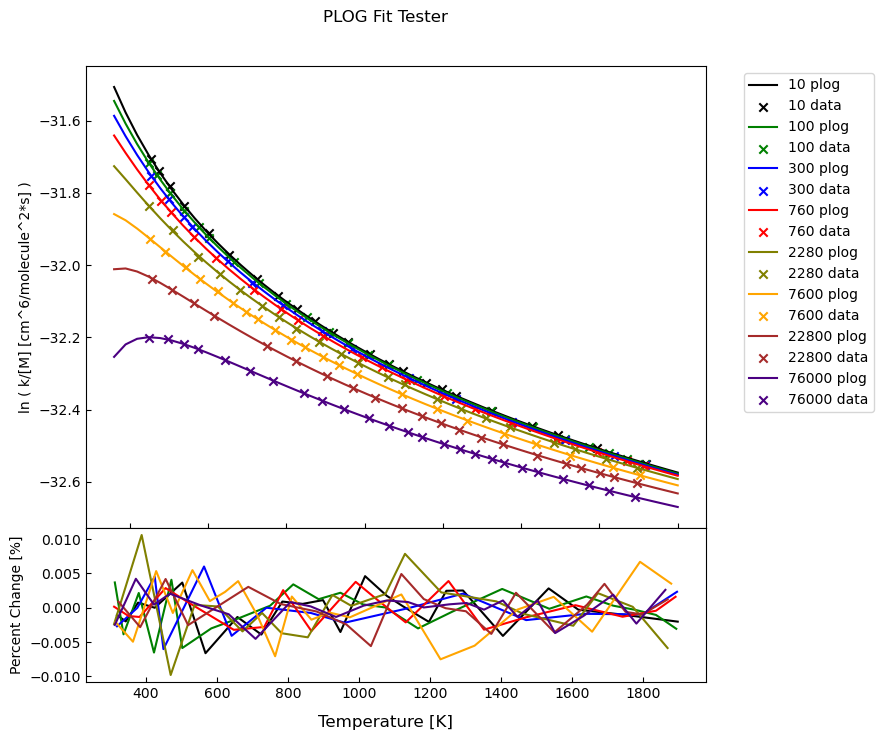

In [11]:
fig = plt.figure(figsize=(8, 8))
spec = gridspec.GridSpec(ncols=1, nrows=2,hspace=0, height_ratios=[3, 1])
fig.suptitle(t='PLOG Fit Tester', x=0.5, y=0.95)
fig.supxlabel(t='Temperature [K]', x=0.5, y=0.05)
ax0 = fig.add_subplot(spec[0])
ax1 = fig.add_subplot(spec[1])
ax0.set_ylabel('ln ( k/[M] [cm^6/molecule^2*s] )')
ax1.set_ylabel('Percent Change [%]')
p_list = [10,100,300,760,2280,7600,22800,76000]
T_list = np.linspace(200,2000,50)
for i, p in enumerate(p_list):
    ratelist_plog = []
    ratelist_troe = []
    for j, T in enumerate(T_list):
        gas = ct.Solution('test/data/sandbox.yaml')
        # print(p)
        gas.TPX = T, p/760, 'H2:0.2,O2:0.2,Ar:0.8'
        rc_plog = gas.forward_rate_constants[gas.reaction_equations().index(reaction_plog)] # m3/kmol/s
        rc_plog = rc_plog*1000 # cm3/mol*s
        rc_plog_M_molec = np.divide(rc_plog, np.square(N_A)) # cm6/molec2*s
        ratelist_plog.append(np.log(rc_plog_M_molec))
    ax0.plot(T_list,ratelist_plog,label=str(p) + ' plog',linestyle='solid',color=pltcolours[i])
    dataset = pd.read_csv(fname) # data from klippy
    dataset_p = dataset[dataset['P(torr)']==p]
    T_data=dataset_p['T']
    k_data_og=dataset_p['lnK/M (cm6/molec^2/sec)']  # cm3/mol/s
    ax0.scatter(T_data,k_data_og,marker='x',color=pltcolours[i],label=str(p) + ' data')
    ax1.plot(T_data, np.multiply(np.divide(np.subtract(np.interp(T_data,T_list,ratelist_plog),k_data_og),k_data_og),100),label=str(p) + ' plog',linestyle='solid',color=pltcolours[i])
ax0.tick_params(direction='in')
ax1.tick_params(direction='in')
ax0.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

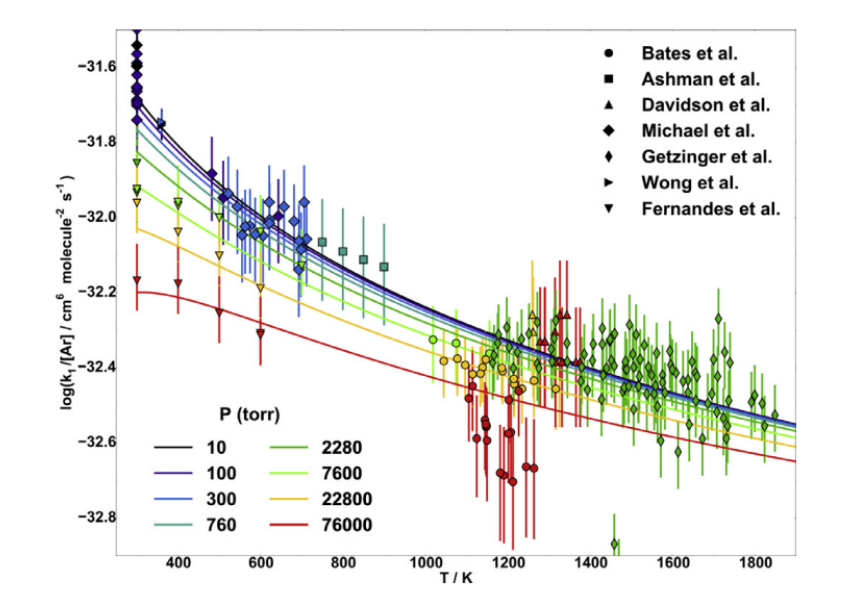

##### **Step 4: Use collision efficiencies to compute low-P limit rate constants for other colliders beyond Ar (i.e., H2O, NH3) in reaction H + O2 (+M) <-> HO2 (+M)**

In [14]:
def k0_fit(collider,T_list,k_list):
    def arrhenius_eq(T,A,beta,Ea):
        R=1.987 #cal/molK
        return A*(T**beta)*np.exp(-Ea/R/T)
    popt, pcov = curve_fit(arrhenius_eq, T_list, np.log(k_list),maxfev = 100000)
    print(('- collider: "%s"\n  low-P-rate-constant: {A: %.5e, b: %.5e, Ea: %.5e}')%(collider.upper(),popt[0],popt[1],popt[2]))
k0_fit("He",[300,1000,2000],[0.90,1.17,1.34])
k0_fit("N2",[300,1000,2000],[1.71,1.58,1.20])
k0_fit("H2",[300,1000,2000],[3.69,3.07,1.71])
k0_fit("CO2",[300,1000,2000],[13.7,8.94,3.03])
k0_fit("NH3",[300,1000,2000],[20.4,17.9,18.7])
k0_fit("H2O",[300,1000,2000],[23.3,22.2,21.3])

- collider: "HE"
  low-P-rate-constant: {A: 6.43747e+16, b: -4.73947e+00, Ea: 1.55302e+04}
- collider: "N2"
  low-P-rate-constant: {A: 1.55845e+06, b: -2.03532e+00, Ea: 1.95097e+03}
- collider: "H2"
  low-P-rate-constant: {A: 1.75756e+05, b: -1.62009e+00, Ea: 1.53171e+03}
- collider: "CO2"
  low-P-rate-constant: {A: 1.17749e+05, b: -1.47748e+00, Ea: 1.36321e+03}
- collider: "NH3"
  low-P-rate-constant: {A: 1.86229e+00, b: 5.63940e-02, Ea: -9.55618e+01}
- collider: "H2O"
  low-P-rate-constant: {A: 3.66010e+00, b: -2.32621e-02, Ea: 1.06680e+01}


#### 1.3) Reaction 69: NH3 <=> NH2 + H
* Was originally written in [alzuetamechanism_LMRR.yaml](https://drive.google.com/file/d/1ln--QaK9phmL9GVVyFz2-jMWSjjMKJ0b/view?usp=sharing) as "NH2 + H (+M) <=> NH3 (+M)", but I reversed the order to allow the tabular data (shown below) to be used
* Copied parameters from Table 1 of ["An experimental, theoretical and kinetic-modeling study of the gas-phase oxidation of ammonia"](https://drive.google.com/file/d/15JVwsEIgb1P6gJmXaWZOH6yQ5QkdQvjg/view?usp=sharing)
* Used the "temperature independent value" of the rate constant for ammonia decomposition (mentioned in the paper) as eig0

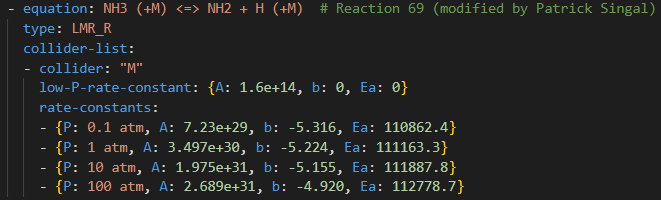 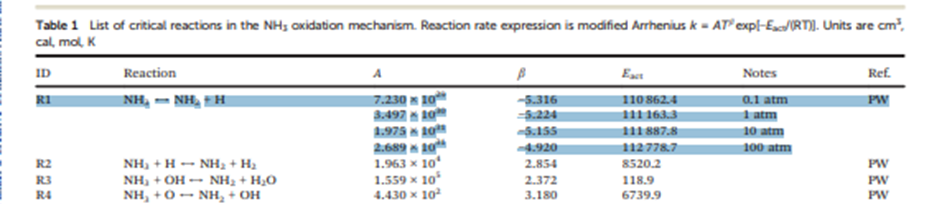

#### 1.4) Reaction 164: HNO (+M) <=> NO + H (+M)
* Was originally written in [alzuetamechanism_LMRR.yaml](https://drive.google.com/file/d/1ln--QaK9phmL9GVVyFz2-jMWSjjMKJ0b/view?usp=sharing) as "NO + H (+M) <=> HNO (+M)", but I reversed the order to allow the tabular data (shown below) to be used
* Copied parameters from Table 1 of ["An experimental, theoretical and kinetic-modeling study of the gas-phase oxidation of ammonia"](https://drive.google.com/file/d/15JVwsEIgb1P6gJmXaWZOH6yQ5QkdQvjg/view?usp=sharing)
* The eig0 value is still UNKNOWN

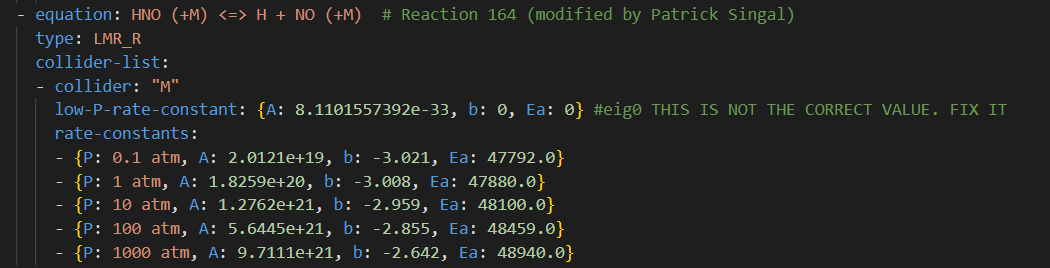
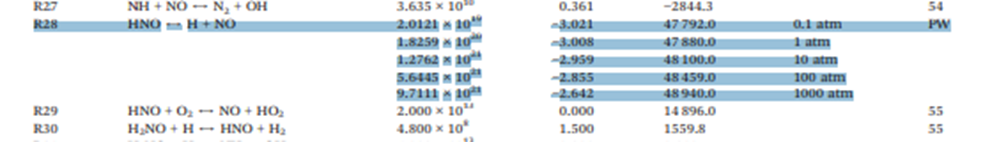

### 2) SPECIES PROFILE: MOLE FRACTION VS TIME
* Figure 5: ["Shock tube/laser absorption measurement of the rate constant of the reaction: H2O2 + CO2 2OH + CO2" (Shao et al.)](https://drive.google.com/file/d/1sFTKvGt-wBRdPPPJMrivpzrz7SSJv9Ee/view?usp=sharing)

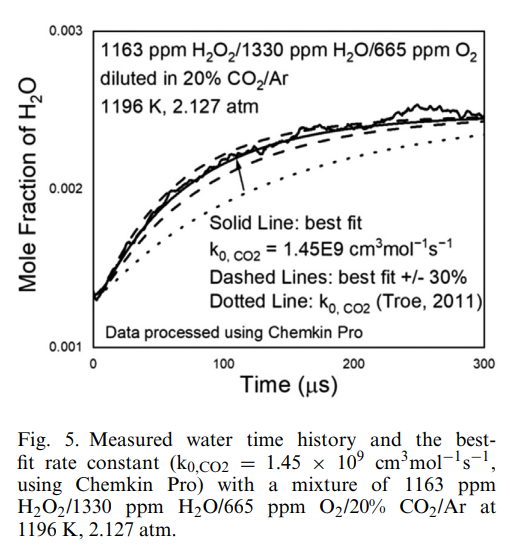

In [15]:
#REPRODUCING FIG 5
refSpecies='H2O'
X_H2O2 = 1163e-6
X_H2O = 1330e-6
X_O2 = 665e-6
X_CO2= 0.2*(1-X_H2O2-X_H2O-X_O2)
X_Ar = 1-X_CO2
def plotXvsTime(fname,pltlabel,pltcolour):
    # gas = ct.Solution('test/data/Burke_H2_ArBath.yaml')
    gas = ct.Solution(fname)
    gas.TPX = 1196, 2.127*101325, {'H2O2':X_H2O2, 'H2O':X_H2O, 'O2':X_O2, 'CO2':X_CO2, 'Ar':X_Ar}
    r = ct.Reactor(contents=gas,energy="on")
    reactorNetwork = ct.ReactorNet([r]) # this will be the only reactor in the network
    timeHistory = ct.SolutionArray(gas, extra=['t'])
    estIgnitDelay = 1
    t = 0
    counter = 1
    while t < estIgnitDelay:
        t = reactorNetwork.step()
        if counter % 20 == 0:
            timeHistory.append(r.thermo.state, t=t)
        counter += 1
    tConv = 1e6 #time conversion factor (1e6 converts to microseconds)
    timeShift=0 # [seconds]
    shiftedTime = tConv*(timeHistory.t - timeShift)
    moleFrac = timeHistory(refSpecies).X 
    plt.plot(shiftedTime, moleFrac, color=pltcolour,label=pltlabel)
plt.figure()
plotXvsTime("test/data/alzuetamechanism.yaml","w/out LMR","k")
plotXvsTime("test/data/alzuetamechanism_LMRR.yaml","w/ LMR","r")
plt.xlim([0,300])
# plt.xlim([100,150])
plt.ylim([0.001,0.003])
# plt.ylim([0.002,0.0022])
plt.ylabel("Mole Fraction of H2O",**hfont)
plt.xlabel("Time (μs)", **hfont)
plt.legend()


### 3) SPECIES PROFILE: CONCENTRATION VS TEMPERATURE
#### 3.1) H2/O2/Ar/H2O mixture 
* Figure 1: ["Mutual inhibition effect of hydrogen and ammonia in oxidation processes and the role of ammonia as “strong” collider in third-molecular reactions" (Sabia et al.)](https://drive.google.com/file/d/1lvcGuuSI6QafO6S_lkemsA5UyTIxl1Lr/view?usp=sharing)

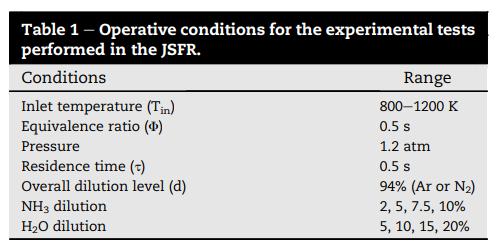
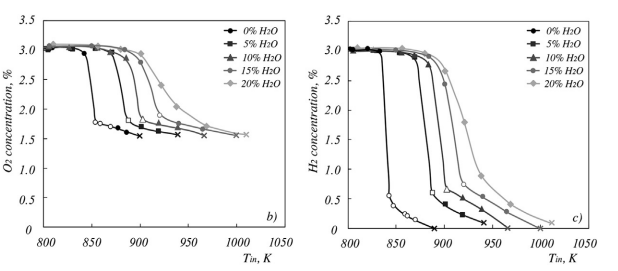

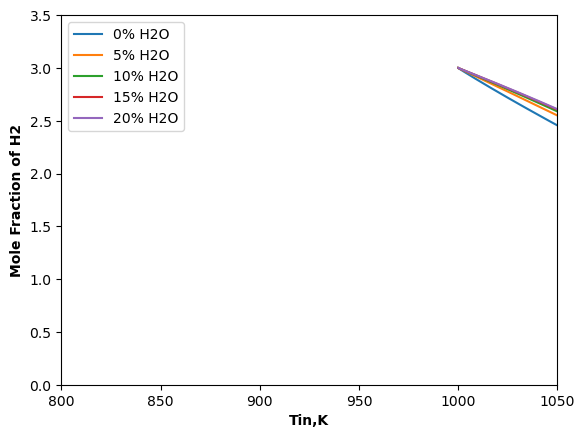

In [22]:
#REPRODUCING FIG 1
def plotXvsTemp(fname,pltlabel,pltcolour,fuel,oxidizer,diluent,refSpecies):
    gas = ct.Solution(fname)
    gas.TP = 1000, 1.2*101325
    gas.set_equivalence_ratio(0.5,fuel,oxidizer,diluent=diluent, fraction={"diluent":0.94},basis='mole')
    # Create a reactor
    reactor = ct.IdealGasReactor(gas)
    # Create a reactor network
    sim = ct.ReactorNet([reactor])
    # Time and data arrays for plotting
    times = []
    temperatures = []
    concentrations_H2 = []
    # Simulate the combustion reaction
    while sim.time < 50e-3:
        sim.step()
        times.append(sim.time)
        temperatures.append(reactor.T)
        concentrations_H2.append(gas[refSpecies].X[0]*100) #multiply by 100 to convert to a percentage
    plt.plot(temperatures,concentrations_H2,label=pltlabel)

plt.figure()
fname="test/data/alzuetamechanism.yaml"
plotXvsTemp(fname,"0% H2O","k",fuel='H2:1',oxidizer='O2:1',diluent='Ar:1.00,H2O:0.00',refSpecies='H2')
plotXvsTemp(fname,"5% H2O","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.95,H2O:0.05",refSpecies='H2')
plotXvsTemp(fname,"10% H2O","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.90,H2O:0.10",refSpecies='H2')
plotXvsTemp(fname,"15% H2O","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.85,H2O:0.15",refSpecies='H2')
plotXvsTemp(fname,"20% H2O","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.80,H2O:0.20",refSpecies='H2')
plt.xlim([800,1050])
plt.ylim([0,3.5])
plt.ylabel("Mole Fraction of H2",**hfont)
plt.xlabel("Tin,K", **hfont)
plt.legend()
plt.show()

#### 3.2) H2/O2/NH3/H2O mixture 
* Figure 2: ["Mutual inhibition effect of hydrogen and ammonia in oxidation processes and the role of ammonia as “strong” collider in third-molecular reactions" (Sabia et al.)](https://drive.google.com/file/d/1lvcGuuSI6QafO6S_lkemsA5UyTIxl1Lr/view?usp=sharing)

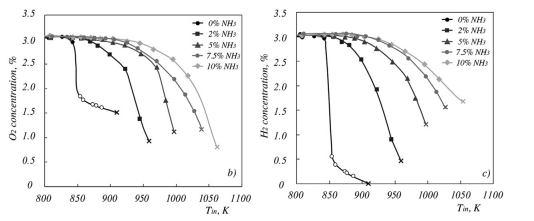

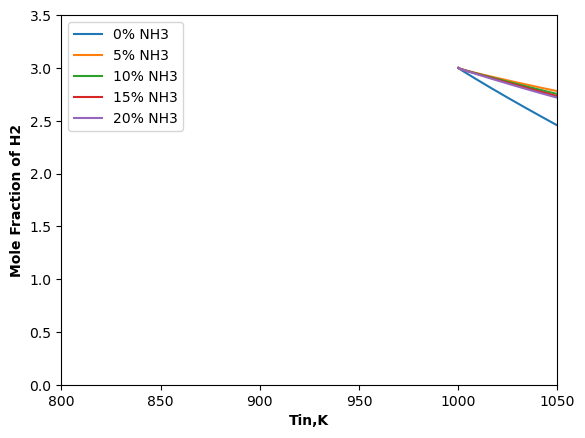

In [23]:
#REPRODUCING FIG 2
plt.figure()
fname="test/data/alzuetamechanism.yaml"
plotXvsTemp(fname,"0% NH3","k",fuel='H2:1',oxidizer='O2:1',diluent='Ar:1.00,NH3:0.00',refSpecies='H2')
plotXvsTemp(fname,"5% NH3","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.95,NH3:0.05",refSpecies='H2')
plotXvsTemp(fname,"10% NH3","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.90,NH3:0.10",refSpecies='H2')
plotXvsTemp(fname,"15% NH3","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.85,NH3:0.15",refSpecies='H2')
plotXvsTemp(fname,"20% NH3","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.80,NH3:0.20",refSpecies='H2')
plt.xlim([800,1050])
plt.ylim([0,3.5])
plt.ylabel("Mole Fraction of H2",**hfont)
plt.xlabel("Tin,K", **hfont)
plt.legend()
plt.show()

### 4) IGNITION DELAY TIME VS. TEMPERATURE
#### 4.1) H2/O2/N2 mixture 


* Figure 12: ["Ignition delay study of moist hydrogen/oxidizer mixtures using a rapid compression machine" (Das et al.)](https://drive.google.com/file/d/15wt6MQaSOY0MV6X_JQWMCGz20SSRR40R/view?usp=sharing)

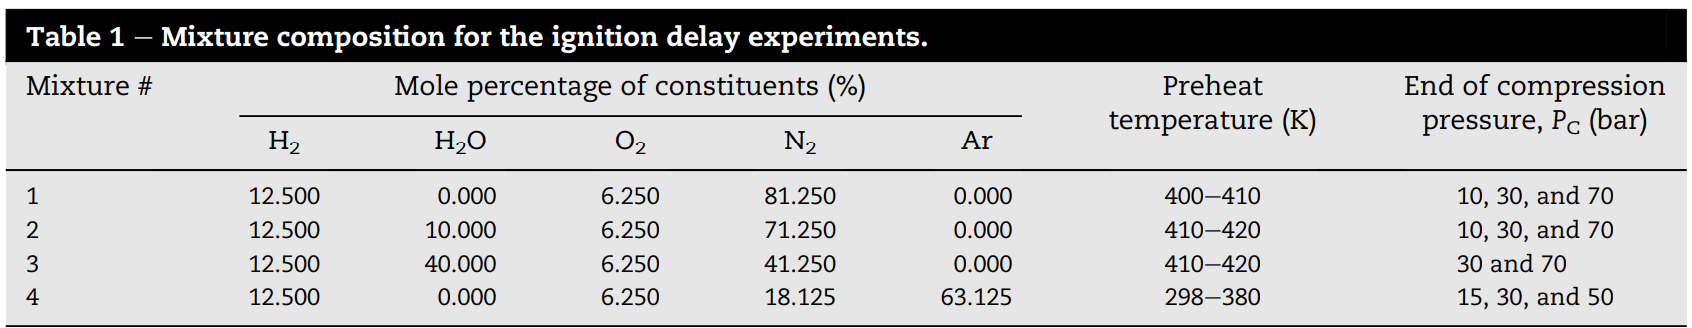

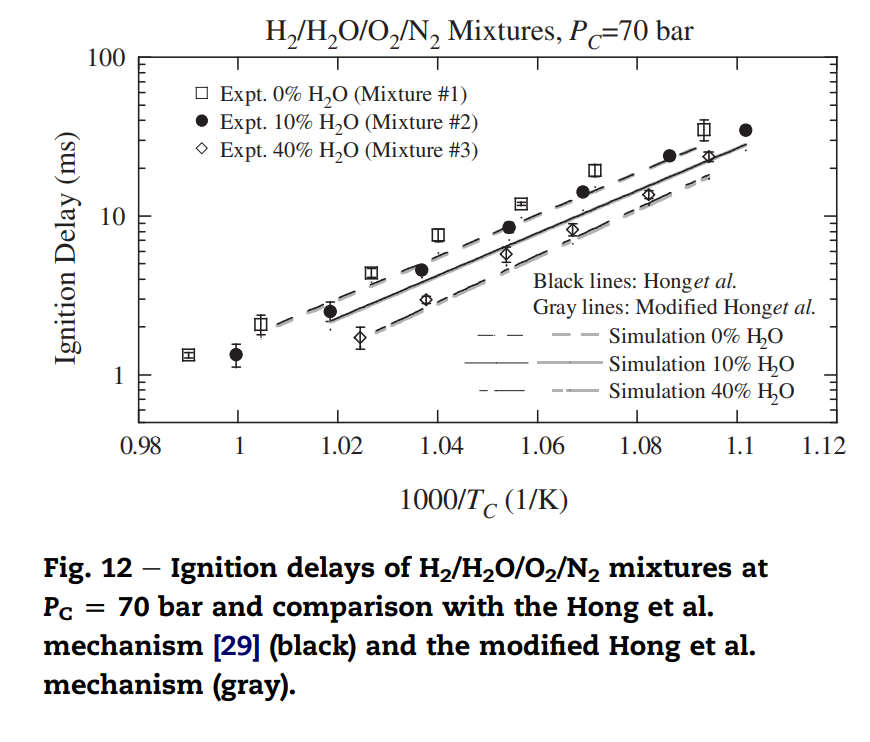

* Further reading: ["Estimation of third body efficiencies from experimental data: Application to hydrogen combustion" (Bertolino et al.)](https://drive.google.com/file/d/1b9eeWRiobquzTYwrdVpy5um8qbhHkl9T/view?usp=sharing)


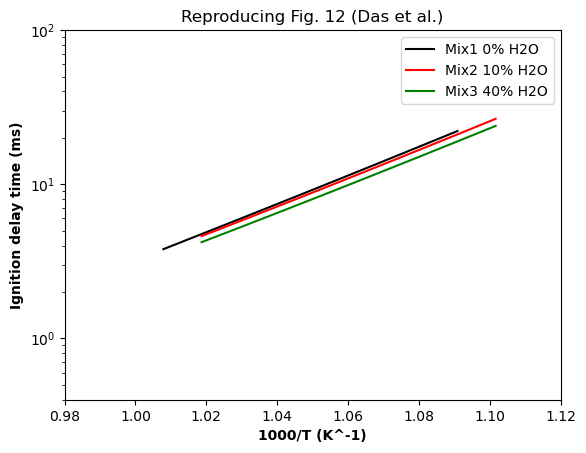

In [25]:
#REPRODUCING FIG 12
def plotIgnitionDelay_Fig12(fname,T,P,X,pltColour,pltLabel="_hidden",tConv=1e3): #tConv=1e3 converts from s to ms by default 
    refSpecies = "OH"
    estimated_ignition_delay_times = np.ones_like(T, dtype=float)
    gas = ct.Solution(fname)
    ignition_delays = ct.SolutionArray(gas, shape=T.shape, extra={"tau": estimated_ignition_delay_times})
    ignition_delays.TPX = T, P, X # [K], [Pa], [-]
    tau_list=[]
    for i, state in enumerate(ignition_delays):
        gas.TPX = state.TPX
        r = ct.Reactor(contents=gas, energy='on')
        reactor_network = ct.ReactorNet([r])
        refSpecies_history = []
        time_history = []
        t = 0
        while t < estimated_ignition_delay_times[i]:
            t = reactor_network.step()
            time_history.append(t)
            refSpecies_history.append(gas[refSpecies].X[0])
        i_ign = np.array(refSpecies_history).argmax()
        tau = time_history[i_ign]
        tau_list.append(tau) 
    plt.semilogy(1000 / ignition_delays.T, np.multiply(tConv,tau_list),'-',color=pltColour, marker=None,label=pltLabel)

plt.figure()
fname='test/data/alzuetamechanism.yaml'
P=70e5

T=np.divide(1000,np.arange(1.00789, 1.0915, 0.001))
X={'H2':0.125, 'O2':0.0625, 'H2O':0, 'N2':0.8125}
plotIgnitionDelay_Fig12(fname,T,P,X,'k',pltLabel='Mix1 0% H2O')

T=np.divide(1000,np.arange(1.018665, 1.10167, 0.001))
X={'H2':0.125, 'O2':0.0625, 'H2O':0.1, 'N2':0.7125}
plotIgnitionDelay_Fig12(fname,T,P,X,'r',pltLabel='Mix2 10% H2O')

T=np.divide(1000,np.arange(1.018665, 1.10167, 0.001))
X={'H2':0.125, 'O2':0.0625, 'H2O':0.4, 'N2':0.4125}
plotIgnitionDelay_Fig12(fname,T,P,X,'g',pltLabel='Mix3 40% H2O')

plt.title("Reproducing Fig. 12 (Das et al.)")
plt.ylabel("Ignition delay time (ms)",**hfont)
plt.xlabel(r"1000/T (K^-1)", **hfont)
plt.ylim([0.4,100])
plt.xlim([0.98,1.12])
plt.legend()
plt.show()

#### 4.2) NH3/O2/Ar mixture 
* Figure 9: ["A shock tube study of fuel concentration effect on high-pressure autoignition delay of ammonia" (Peng et al.)](https://drive.google.com/file/d/1JO1HS3WTDgLyB6KY0jVLoKAWNhu3Th0B/view?usp=sharing)

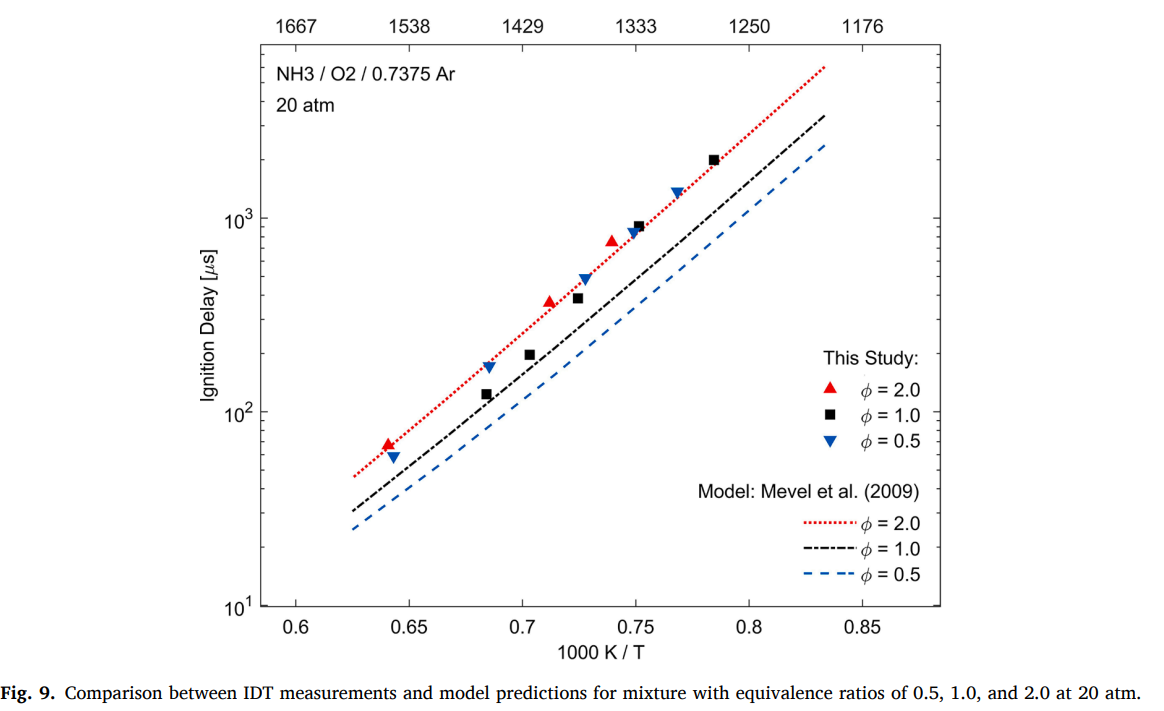

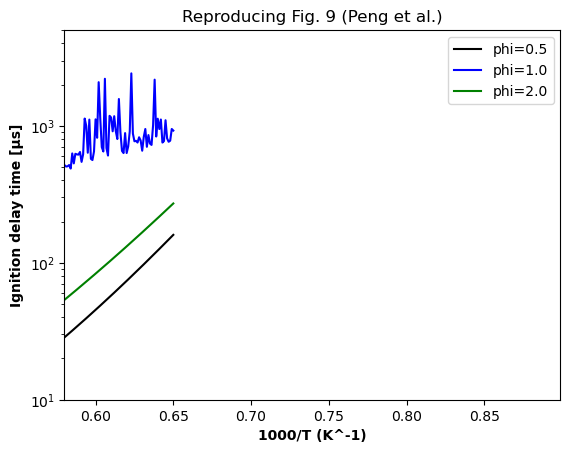

In [23]:
#REPRODUCING FIG 9
def plotIgnitionDelay_Fig9(fname,phi,pltColour,pltLabel="_hidden"): #ign delays plotted in units of μs by default
    T=np.divide(1000,np.arange(0.47, 0.65, 0.001))
    P=20*101325
    refSpecies = "O"
    estimated_ignition_delay_times = 0.7*np.ones_like(T, dtype=float)
    gas = ct.Solution(fname)
    ignition_delays = ct.SolutionArray(gas, shape=T.shape, extra={"tau": estimated_ignition_delay_times})
    ignition_delays.TP = T, P
    ignition_delays.set_equivalence_ratio(phi,'NH3','O2',diluent='Ar:1', fraction={"diluent":0.7375},basis='mole')
    tau_list=[]
    for i, state in enumerate(ignition_delays):
        gas.TPX = state.TPX
        r = ct.Reactor(contents=gas, energy='on')
        reactor_network = ct.ReactorNet([r])
        refSpecies_history = []
        time_history = []
        t = 0
        while t < estimated_ignition_delay_times[i]:
            t = reactor_network.step()
            time_history.append(t)
            refSpecies_history.append(gas[refSpecies].X[0])
        i_ign = np.array(refSpecies_history).argmax()
        tau = time_history[i_ign]
        tau_list.append(tau) 
    plt.semilogy(1000 / ignition_delays.T, np.multiply(1e6,tau_list),'-',color=pltColour, marker=None,label=pltLabel)


plt.figure()
fname='test/data/alzuetamechanism.yaml'
plotIgnitionDelay_Fig9(fname,0.5,'k',pltLabel="phi=0.5")
plotIgnitionDelay_Fig9(fname,1.0,'b',pltLabel="phi=1.0")
plotIgnitionDelay_Fig9(fname,2.0,'g',pltLabel="phi=2.0")

plt.title("Reproducing Fig. 9 (Peng et al.)")
plt.ylabel("Ignition delay time [μs]",**hfont)
plt.xlabel(r"1000/T (K^-1)", **hfont)
plt.ylim([10,5000])
plt.xlim([0.58,0.899])
plt.legend()
plt.show()

### 5) FLAME BURNING RATE PLOTS
#### 5.1) H2/O2/He mixture 
* Figure 1, 2: ["Assessment of kinetic modeling for lean H2/CH4/O2/diluent flames at high pressures" (Burke et al.)](https://drive.google.com/file/d/1SP44K4k0oS81g19Gny2TQxCgBMXFXboB/view?usp=sharing)
* Further reading: ["Evaluating Mixture Rules for Multi-Component Pressure Dependence: H+O2 (+M)=HO2 (+M)" (Burke et al.)](https://drive.google.com/file/d/1VsMwxM_VrQSqbVT4c5ARn_KthV4oLiWJ/view?usp=sharing), ["Negative pressure dependence of mass burning rates of H2/CO/O2/diluent flames at low flame temperatures" (Burke et al.)](https://drive.google.com/file/d/1vTAJ_EpAyKNhtb_uAUpahS91CbWAw3Ej/view?usp=sharing)

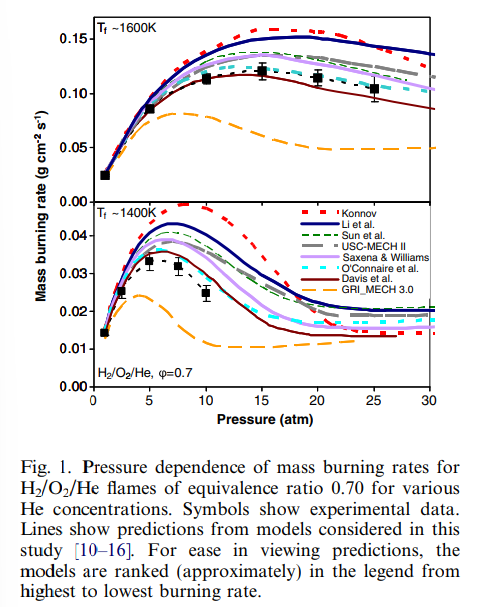


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      1.78e-06      6.167
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.175e-11      6.152
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps   
 
*******************************************************************************
CanteraError thrown by OneDim::timeStep:
Time integration failed.
*******************************************************************************
 

******** Initial solve failed; Retrying with energy equation disabled ********

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001281      2.435
Attempt Newton solution of steady-state prob

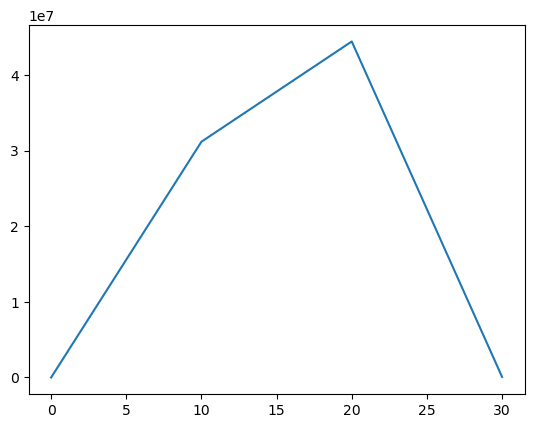

In [32]:
# REPRODUCING BURKE FIGURE 1

# I need to plot the mass burning rate, not the flame speed. How do I do this?

def plotFlameSpeed_BurkeFig1(fname,T):
    P=np.linspace(0.001,30,4)#Using a very small number of points in P array for now, because otherwise sim time would be too long
    phi=0.7
    # width=[0.08,0.03,0.015,0.008]
    width=0.03 #[m] how do we know the flame width?
    loglevel = 1 # amount of diagnostic output (0 to 8)
    fspeed=[]
    for j in range(len(P)):
        # Solution object used to compute mixture properties, set to the state of the
        # upstream fuel-air mixture
        gas = ct.Solution(fname)
        gas.TP = T, P[j]*ct.one_atm
        gas.set_equivalence_ratio(phi,'H2','O2',diluent='He:1', fraction={"diluent":0.3},basis='mole') # NOTE: DILUENT FRACTION OF 0.3 IS A PLACEHOLDER. MUST FIND REAL NUMBER.
        # Create the flame object
        f = ct.FreeFlame(gas,width=width)
        f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12) # Define tolerances for the solver
        # f.show()
        f.transport_model='multicomponent'
        f.solve(loglevel,auto=True)
        fspeed.append(f.velocity[0]) #[m/s] multicomponent flame speed
        print(f.velocity[0])
    print(fspeed)
    plt.plot(P,fspeed)
    
plt.figure()
plotFlameSpeed_BurkeFig1('test/data/alzuetamechanism.yaml',T=1400)
plotFlameSpeed_BurkeFig1('test/data/alzuetamechanism.yaml',T=1600)
plt.show()

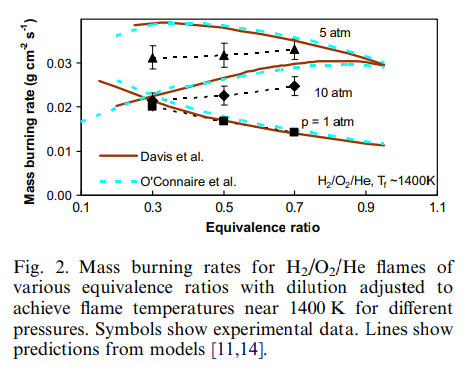

In [ ]:
# REPRODUCING BURKE FIGURE 2

# I need to plot the mass burning rate, not the flame speed. How do I do this?

def plotFlameSpeed_BurkeFig2(fname,P):
    T=1400
    phi=np.linspace(0.15,1.0,4)#Using a very small number of points in phi array for now, because otherwise sim time would be too long
    # width=[0.08,0.03,0.015,0.008]
    width=0.03 #[m] how do we know the flame width?
    loglevel = 1 # amount of diagnostic output (0 to 8)
    fspeed=[]
    for j in range(len(phi)):
        # Solution object used to compute mixture properties, set to the state of the
        # upstream fuel-air mixture
        gas = ct.Solution(fname)
        gas.TP = T, P*ct.one_atm
        gas.set_equivalence_ratio(phi[j],'H2','O2',diluent='He:1', fraction={"diluent":0.3},basis='mole') # NOTE: DILUENT FRACTION OF 0.3 IS A PLACEHOLDER. MUST FIND REAL NUMBER.
        # Create the flame object
        f = ct.FreeFlame(gas,width=width)
        f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12) # Define tolerances for the solver
        # f.show()
        f.transport_model='multicomponent'
        f.solve(loglevel,auto=True)
        fspeed.append(f.velocity[0]) #[m/s] multicomponent flame speed
        print(f.velocity[0])
    print(fspeed)
    plt.plot(phi,fspeed)

#REPRODUCING FIGURE 2
plt.figure()
plotFlameSpeed_BurkeFig2('test/data/alzuetamechanism.yaml',P=1)
plotFlameSpeed_BurkeFig2('test/data/alzuetamechanism.yaml',P=5)
plotFlameSpeed_BurkeFig2('test/data/alzuetamechanism.yaml',P=10)
plt.show()

#### 5.2) H2/H2O mixture 
* Figure 2a: ["The effects of water dilution on hydrogen, syngas, and ethylene flames at elevated pressure" (Santner et al.)](https://drive.google.com/file/d/1eijNHH4XoFlrORzyl55VKOU7b3VqTWie/view?usp=sharing)

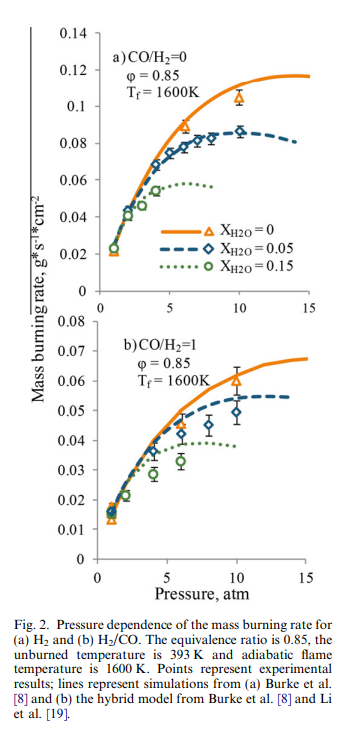

In [1]:
# REPRODUCING SANTNER FIGURE 2A

def plotFlameSpeed_SantnerFig2A(fname,X_H2O):
    P=np.linspace(0.001,30,4)#Using a very small number of points in P array for now, because otherwise sim time would be too long
    phi=0.85
    T=1600
    # width=[0.08,0.03,0.015,0.008]
    width=0.03 #[m] how do we know the flame width?
    loglevel = 1 # amount of diagnostic output (0 to 8)
    fspeed=[]
    for j in range(len(P)):
        # Solution object used to compute mixture properties, set to the state of the
        # upstream fuel-air mixture
        gas = ct.Solution(fname)
        gas.TP = T, P[j]*ct.one_atm
        gas.set_equivalence_ratio(phi,'H2','O2',diluent='H2O:1', fraction={"diluent":X_H2O},basis='mole') # NOTE: NEED TO CHECK IF THE OXIDIZER IS ACTUALLY O2
        # Create the flame object
        f = ct.FreeFlame(gas,width=width)
        f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12) # Define tolerances for the solver
        # f.show()
        f.transport_model='multicomponent'
        f.solve(loglevel,auto=True)
        fspeed.append(f.velocity[0]) #[m/s] multicomponent flame speed
        print(f.velocity[0])
    print(fspeed)
    plt.plot(P,fspeed)
    
plt.figure()
plotFlameSpeed_SantnerFig2A('test/data/alzuetamechanism.yaml',X_H2O=0.00)
plotFlameSpeed_SantnerFig2A('test/data/alzuetamechanism.yaml',X_H2O=0.05)
plotFlameSpeed_SantnerFig2A('test/data/alzuetamechanism.yaml',X_H2O=0.15)
plt.show()


KeyboardInterrupt



#### 5.3) NH3/air mixture 
* Figure 1: ["Effect of Chemistry and Transport Properties on Near-Limit Flames at Microgravity" (Paul D Ronney)](https://drive.google.com/file/d/187j_Co3Qqg4c6BtydoD7PCRcT2uURtrj/view?usp=sharing)

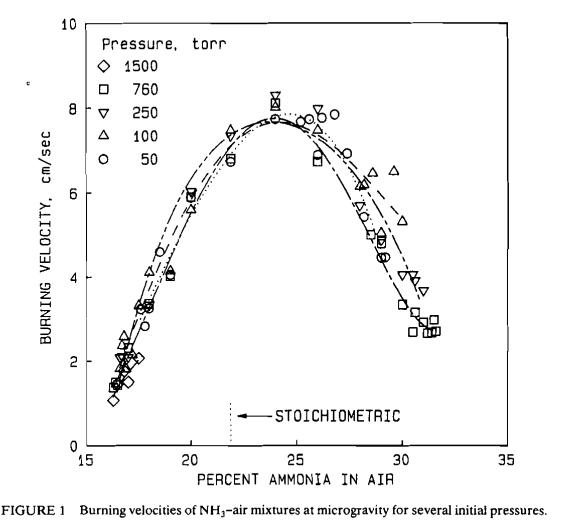

In [ ]:
# REPRODUCING RONNEY FIGURE 1

def plotFlameSpeed_RonneyFig1(fname,P):
    X_NH3=np.linspace(0.16,0.32,4)#Using a very small number of points in X_NH3 array for now, because otherwise sim time would be too long
    X_air = 1-X_NH3
    X_O2 = 1/(1+3.76)*X_air
    X_N2 = 1-X_NH3-X_O2
    T=1600 #THIS IS A PLACEHOLDER. STILL NEED TO FIND REAL VALUE OF TEMPERATURE
    width=0.03
    loglevel = 1
    fspeed=[]
    for j in range(len(X_NH3)):
        gas = ct.Solution(fname)
        gas.TP = T, P[j]*ct.one_atm
        gas.X = {'NH3':X_NH3[j],'O2':X_O2,'N2':X_N2}
        f = ct.FreeFlame(gas,width=width)
        f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12)
        f.transport_model='multicomponent'
        f.solve(loglevel,auto=True)
        fspeed.append(f.velocity[0])
        print(f.velocity[0])
    print(fspeed)
    plt.plot(X_NH3,fspeed)
    
plt.figure()
plotFlameSpeed_RonneyFig1('test/data/alzuetamechanism.yaml',P=760/50)
plotFlameSpeed_RonneyFig1('test/data/alzuetamechanism.yaml',P=760/100)
plotFlameSpeed_RonneyFig1('test/data/alzuetamechanism.yaml',P=760/250)
plotFlameSpeed_RonneyFig1('test/data/alzuetamechanism.yaml',P=760/760)
plotFlameSpeed_RonneyFig1('test/data/alzuetamechanism.yaml',P=760/1500)
plt.show()